In [1]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.kangkang_fnn_models import KangFeedForwardNetwork
from dataloaders.flat_loader import FlatDataLoaders
from datasets.flat_dataset import FlatDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score

In [2]:
data_dim_str = "T24H-X850M-Y880M"  # needs to exist
model_name = "FNN-CRIME-MODEL"  # needs to be created

data_path = f"./data/processed/{data_dim_str}/"
model_path = data_path + f"models/{model_name}/"
os.makedirs(data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")

timer = Timer()
# manually set the config
conf_dict = {
    "seed":3,
    "resume":False,
    "early_stopping":False,
    "sub_sample_train_set": True,
    "sub_sample_validation_set": True,
    "sub_sample_test_set": False,    
    "use_cuda":False,
    "val_ratio":0.1,
    "tst_ratio":0.2,
    "flatten_grid": True,
    "lr":1e-3,
    "weight_decay":1e-8,
    "max_epochs":5,
    "batch_size":256,
    "dropout": 0.1,
    "shuffle":False,
    "seq_len":0,
}
conf = BaseConf(conf_dict=conf_dict)

info = deepcopy(conf.__dict__)
info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

# DATA LOADER SETUP
np.random.seed(conf.seed)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed(conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")
info["device"] = device.type

# GET DATA
loaders = FlatDataLoaders(data_path=data_path, conf=conf)

2019-08-19T16:53:02 | root | INFO | =====================================BEGIN=====================================
2019-08-19T16:53:02 | root | INFO | Device: cpu
2019-08-19T16:53:02 | root | INFO | Data shapes of files in generated_data.npz
2019-08-19T16:53:02 | root | INFO | 	crime_feature_indices shape (11,)
2019-08-19T16:53:02 | root | INFO | 	crime_types_grids shape (365, 11, 47, 33)
2019-08-19T16:53:02 | root | INFO | 	crime_grids shape (365, 1, 47, 33)
2019-08-19T16:53:02 | root | INFO | 	demog_grid shape (1, 37, 47, 33)
2019-08-19T16:53:02 | root | INFO | 	street_grid shape (1, 512, 47, 33)
2019-08-19T16:53:02 | root | INFO | 	time_vectors shape (366, 43)
2019-08-19T16:53:02 | root | INFO | 	weather_vectors shape (365, 11)
2019-08-19T16:53:02 | root | INFO | 	x_range shape (33,)
2019-08-19T16:53:02 | root | INFO | 	y_range shape (47,)
2019-08-19T16:53:02 | root | INFO | 	t_range shape (366,)


In [3]:
# TRAIN MODEL
spc_feats, tmp_feats, env_feats, target = loaders.training_generator.dataset[0]
spc_size, tmp_size, env_size = spc_feats.shape[-1], tmp_feats.shape[-1], env_feats.shape[-1]

model = KangFeedForwardNetwork(spc_size=spc_size, tmp_size=tmp_size, env_size=env_size, dropout_p=conf.dropout)
model.to(device)

KangFeedForwardNetwork(
  (dropout): Dropout(p=0.1)
  (spcNet): Sequential(
    (0): Linear(in_features=37, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
  )
  (tmpNet): Sequential(
    (0): Linear(in_features=66, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
  )
  (envNet): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
  )
  (finalNet): Sequential(
    (0): Linear(in_features=384, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=T

In [4]:
loss_function = nn.CrossEntropyLoss()

trn_loss = []
val_loss = []
val_loss_best = float("inf")

all_trn_loss = []
all_val_loss = []

optimiser = optim.Adam(params=model.parameters(), lr=conf.lr, weight_decay=conf.weight_decay)
if conf.resume:
    # load model and optimiser states
    model.load_state_dict(torch.load(model_path + "model_best.pth"))
    optimiser.load_state_dict(torch.load(model_path + "optimiser_best.pth"))
    # load losses
    losses_zip = np.load(model_path + "losses.npz")
    all_val_loss = losses_zip["all_val_loss"].tolist()
    val_loss = losses_zip["val_loss"].tolist()
    trn_loss = losses_zip["trn_loss"].tolist()
    all_trn_loss = losses_zip["all_trn_loss"].tolist()
    val_loss_best = float(losses_zip["val_loss_best"])
    # todo only load loss since last best_checkpoint

In [5]:
spc_feats, tmp_feats, env_feats, targets = next(iter(loaders.training_generator))
for i in [spc_feats, tmp_feats, env_feats, targets]:
    print(i.shape)

(256, 37)
(256, 66)
(256, 512)
(256,)


In [6]:
for epoch in range(conf.max_epochs):
    log.info(f"Epoch: {(1+epoch):04d}/{conf.max_epochs:04d}")
    timer.reset()
    # Training loop
    tmp_trn_loss = []
    num_batches = loaders.training_generator.num_batches
    for spc_feats, tmp_feats, env_feats, targets in loaders.training_generator:
        current_batch = loaders.training_generator.current_batch

        
        # Transfer to GPU
        spc_feats = torch.Tensor(spc_feats).to(device)
        tmp_feats = torch.Tensor(tmp_feats).to(device)
        env_feats = torch.Tensor(env_feats).to(device)
        targets = torch.LongTensor(targets).to(device)
        out = model(spc_feats, tmp_feats, env_feats)

        loss = loss_function(out, targets)
        tmp_trn_loss.append(loss.item())
        all_trn_loss.append(tmp_trn_loss[-1])

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        log.debug(f"Batch: {current_batch:04d}/{num_batches:04d} \t Loss: {tmp_trn_loss[-1]:.4f}")
    trn_loss.append(np.mean(tmp_trn_loss))
    log.debug(f"Epoch {epoch} -> Training Loop Duration: {timer.check()}")
    timer.reset()

    # Validation loop
    tmp_val_loss = []
    with torch.set_grad_enabled(False):
        # Transfer to GPU
        for spc_feats, tmp_feats, env_feats, targets in loaders.validation_generator:
            # Transfer to GPU
            spc_feats = torch.Tensor(spc_feats).to(device)
            tmp_feats = torch.Tensor(tmp_feats).to(device)
            env_feats = torch.Tensor(env_feats).to(device)
            targets = torch.LongTensor(targets).to(device)
            out = model(spc_feats, tmp_feats, env_feats)

            loss = loss_function(out, targets)
            tmp_val_loss.append(loss.item())
            all_val_loss.append(tmp_val_loss[-1])
    val_loss.append(np.mean(tmp_val_loss))
    log.debug(f"Epoch {epoch} -> Validation Loop Duration: {timer.check()}")

    log.info(f"\tLoss (Trn): \t{trn_loss[-1]:.5f}")
    log.info(f"\tLoss (Val): \t{val_loss[-1]:.5f}")
    log.info(f"\tLoss (Dif): \t{np.abs(val_loss[-1]-trn_loss[-1]):.5f}\n")        
    


    # save best model
    if min(val_loss) < val_loss_best:
        val_loss_best = min(val_loss)
        torch.save(model.state_dict(), model_path + "model_best.pth")
        torch.save(optimiser.state_dict(), model_path + "optimiser_best.pth")

    # model has been over-fitting stop maybe? # average of val_loss has increase - starting to over-fit
    if conf.early_stopping and epoch != 0 and val_loss[-1] > val_loss[-2]:
        log.warning("Over-fitting has taken place - stopping early")
        break

    # checkpoint - save models and loss values
    torch.save(model.state_dict(), model_path + "model.pth")
    torch.save(optimiser.state_dict(), model_path + "optimiser.pth")
    np.savez_compressed(model_path + "losses.npz",
                        all_val_loss=all_val_loss,
                        val_loss=val_loss,
                        trn_loss=trn_loss,
                        all_trn_loss=all_trn_loss,
                        val_loss_best=val_loss_best)

2019-08-19T16:53:04 | root | INFO | Epoch: 0001/0005
2019-08-19T16:53:42 | root | INFO | 	Loss (Trn): 	0.54244
2019-08-19T16:53:42 | root | INFO | 	Loss (Val): 	0.53041
2019-08-19T16:53:42 | root | INFO | 	Loss (Dif): 	0.01203

2019-08-19T16:53:42 | root | INFO | Epoch: 0002/0005
2019-08-19T16:54:20 | root | INFO | 	Loss (Trn): 	0.52480
2019-08-19T16:54:20 | root | INFO | 	Loss (Val): 	0.52412
2019-08-19T16:54:20 | root | INFO | 	Loss (Dif): 	0.00068

2019-08-19T16:54:20 | root | INFO | Epoch: 0003/0005
2019-08-19T16:54:58 | root | INFO | 	Loss (Trn): 	0.52181
2019-08-19T16:54:58 | root | INFO | 	Loss (Val): 	0.52440
2019-08-19T16:54:58 | root | INFO | 	Loss (Dif): 	0.00259

2019-08-19T16:54:58 | root | INFO | Epoch: 0004/0005
2019-08-19T16:55:36 | root | INFO | 	Loss (Trn): 	0.51971
2019-08-19T16:55:36 | root | INFO | 	Loss (Val): 	0.52260
2019-08-19T16:55:36 | root | INFO | 	Loss (Dif): 	0.00289

2019-08-19T16:55:36 | root | INFO | Epoch: 0005/0005
2019-08-19T16:56:13 | root | INFO |

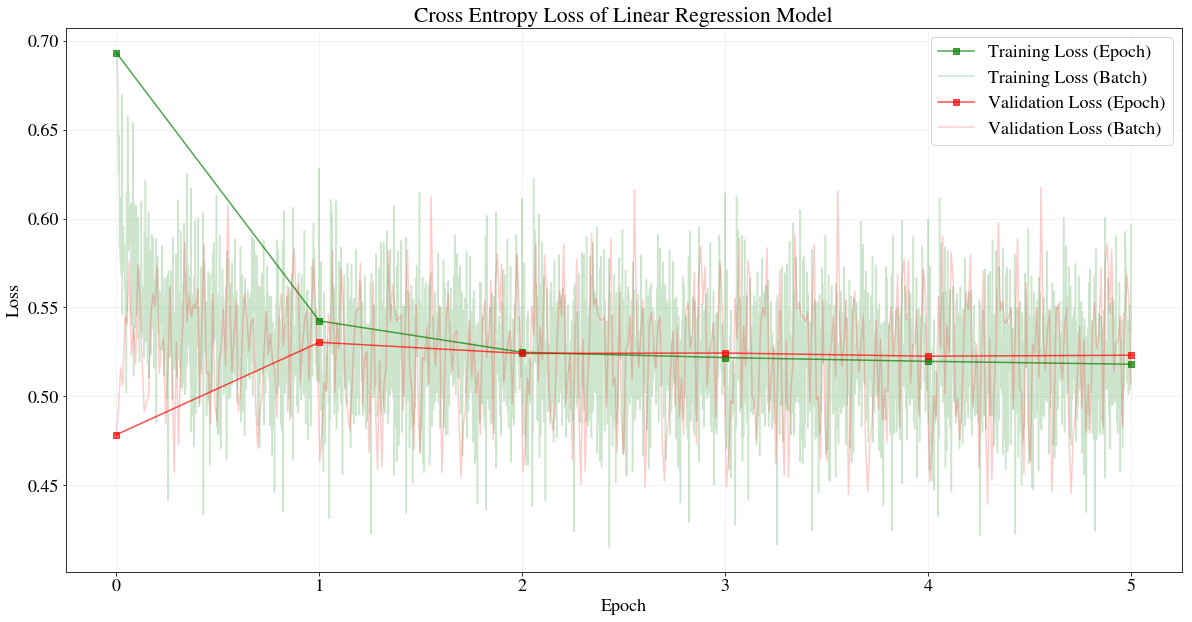

In [7]:
# Save training and validation plots
skip = 0
loss_plotter = LossPlotter(title="Cross Entropy Loss of Linear Regression Model")
loss_plotter.plot_losses(trn_loss, all_trn_loss[skip:], val_loss, all_val_loss[skip:])
loss_plotter.savefig(model_path + "plot_train_val_loss.png")

# todo evaluation prediction formating into an actual map

2019-08-19T16:56:14 | root | INFO | Data shapes of files in generated_data.npz
2019-08-19T16:56:14 | root | INFO | 	crime_feature_indices shape (11,)
2019-08-19T16:56:14 | root | INFO | 	crime_types_grids shape (365, 11, 47, 33)
2019-08-19T16:56:14 | root | INFO | 	crime_grids shape (365, 1, 47, 33)
2019-08-19T16:56:14 | root | INFO | 	demog_grid shape (1, 37, 47, 33)
2019-08-19T16:56:14 | root | INFO | 	street_grid shape (1, 512, 47, 33)
2019-08-19T16:56:14 | root | INFO | 	time_vectors shape (366, 43)
2019-08-19T16:56:14 | root | INFO | 	weather_vectors shape (365, 11)
2019-08-19T16:56:14 | root | INFO | 	x_range shape (33,)
2019-08-19T16:56:14 | root | INFO | 	y_range shape (47,)
2019-08-19T16:56:14 | root | INFO | 	t_range shape (366,)
2019-08-19T16:56:19 | root | INFO | Accuracy:		 0.7205
2019-08-19T16:56:19 | root | INFO | ROC AUC:		 0.8068
2019-08-19T16:56:19 | root | INFO | Average Precision:	 0.7319
2019-08-19T16:56:19 | root | INFO | =====================================END==

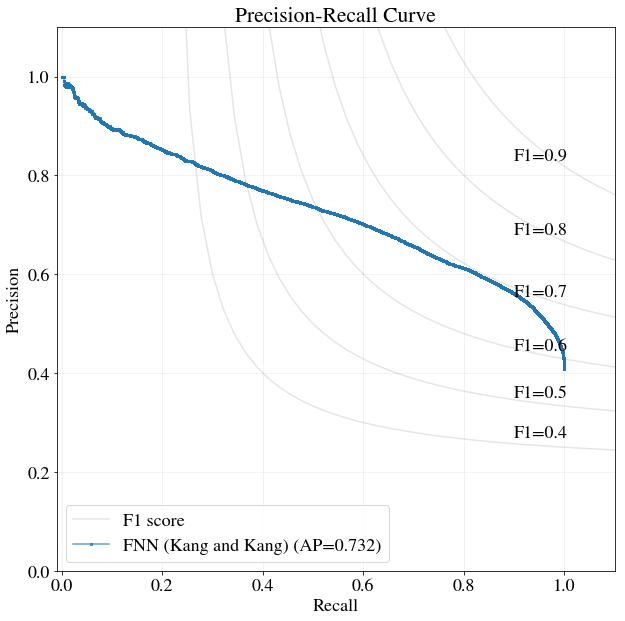

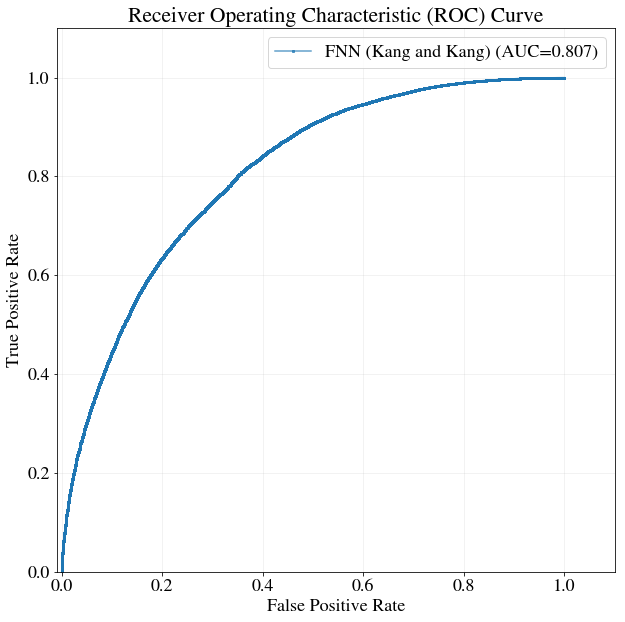

In [8]:
model.load_state_dict(torch.load(model_path + "model_best.pth"))
conf = BaseConf(conf_dict=conf_dict)
loaders = FlatDataLoaders(data_path=data_path, conf=conf)

# EVALUATE MODEL
with torch.set_grad_enabled(False):
    # Transfer to GPU
    testing_losses = []
    y_true = []
    y_pred = []
    probas_pred = []
    
    # loop through is set does not fit in batch
    for spc_feats, tmp_feats, env_feats, targets in loaders.testing_generator: 
        # Transfer to GPU
        spc_feats = torch.Tensor(spc_feats).to(device)
        tmp_feats = torch.Tensor(tmp_feats).to(device)
        env_feats = torch.Tensor(env_feats).to(device)
        targets = torch.LongTensor(targets).to(device)
        
        y_true.extend(targets.tolist())
        out = model(spc_feats, tmp_feats, env_feats)
        out = F.softmax(out, dim=1)
        out_label = torch.argmax(out, dim=1)
        y_pred.extend(out_label.tolist())
        out_proba = out[:, 1]  # likelihood of crime is more general form - when comparing to moving averages
        probas_pred.extend(out_proba.tolist())

acc = accuracy_score(y_true, y_pred)
auc = roc_auc_score(y_true, probas_pred)
ap = average_precision_score(y_true, probas_pred)
log.info(f"Accuracy:\t\t {acc:.4f}")
log.info(f"ROC AUC:\t\t {auc:.4f}")
log.info(f"Average Precision:\t {ap:.4f}")

np.savez_compressed(model_path + "evaluation_results.npz",
                    acc=acc,
                    auc=auc,
                    ap=ap,
                    y_true=y_true,
                    y_pred=y_pred,
                    probas_pred=probas_pred)

pr_plotter = PRCurvePlotter()
pr_plotter.add_curve(y_true, probas_pred, label_name="FNN (Kang and Kang)")
pr_plotter.savefig(model_path + "plot_pr_curve.png")

roc_plotter = ROCCurvePlotter()
roc_plotter.add_curve(y_true, probas_pred, label_name="FNN (Kang and Kang)")
roc_plotter.savefig(model_path + "plot_roc_curve.png")

info["stop_time"] = strftime("%Y-%m-%dT%H:%M:%S")
write_json(info, model_path + "info.json")

log.info("=====================================END=====================================")

2019-08-19T16:56:20 | root | INFO | Data shapes of files in generated_data.npz
2019-08-19T16:56:20 | root | INFO | 	crime_feature_indices shape (11,)
2019-08-19T16:56:20 | root | INFO | 	crime_types_grids shape (365, 11, 47, 33)
2019-08-19T16:56:20 | root | INFO | 	crime_grids shape (365, 1, 47, 33)
2019-08-19T16:56:20 | root | INFO | 	demog_grid shape (1, 37, 47, 33)
2019-08-19T16:56:20 | root | INFO | 	street_grid shape (1, 512, 47, 33)
2019-08-19T16:56:20 | root | INFO | 	time_vectors shape (366, 43)
2019-08-19T16:56:20 | root | INFO | 	weather_vectors shape (365, 11)
2019-08-19T16:56:20 | root | INFO | 	x_range shape (33,)
2019-08-19T16:56:20 | root | INFO | 	y_range shape (47,)
2019-08-19T16:56:20 | root | INFO | 	t_range shape (366,)
2019-08-19T16:56:25 | root | INFO | Accuracy:		 0.7241
2019-08-19T16:56:25 | root | INFO | ROC AUC:		 0.8069
2019-08-19T16:56:25 | root | INFO | Average Precision:	 0.7324
2019-08-19T16:56:26 | root | INFO | =====================================END==

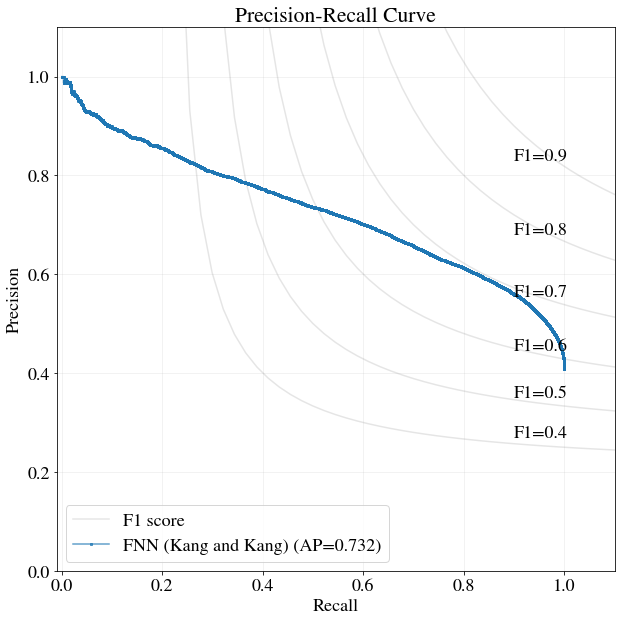

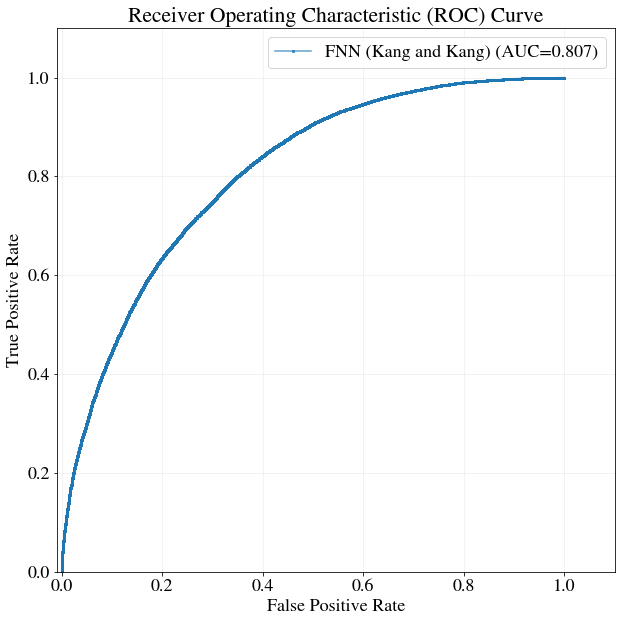

In [9]:
model.load_state_dict(torch.load(model_path + "model.pth"))
conf = BaseConf(conf_dict=conf_dict)
loaders = FlatDataLoaders(data_path=data_path, conf=conf)

# EVALUATE MODEL
with torch.set_grad_enabled(False):
    # Transfer to GPU
    testing_losses = []
    y_true = []
    y_pred = []
    probas_pred = []
    
    # loop through is set does not fit in batch
    for spc_feats, tmp_feats, env_feats, targets in loaders.testing_generator: 
        # Transfer to GPU
        spc_feats = torch.Tensor(spc_feats).to(device)
        tmp_feats = torch.Tensor(tmp_feats).to(device)
        env_feats = torch.Tensor(env_feats).to(device)
        targets = torch.LongTensor(targets).to(device)
        
        y_true.extend(targets.tolist())
        out = model(spc_feats, tmp_feats, env_feats)
        out = F.softmax(out, dim=1)
        out_label = torch.argmax(out, dim=1)
        y_pred.extend(out_label.tolist())
        out_proba = out[:, 1]  # likelihood of crime is more general form - when comparing to moving averages
        probas_pred.extend(out_proba.tolist())

acc = accuracy_score(y_true, y_pred)
auc = roc_auc_score(y_true, probas_pred)
ap = average_precision_score(y_true, probas_pred)
log.info(f"Accuracy:\t\t {acc:.4f}")
log.info(f"ROC AUC:\t\t {auc:.4f}")
log.info(f"Average Precision:\t {ap:.4f}")

np.savez_compressed(model_path + "evaluation_results.npz",
                    acc=acc,
                    auc=auc,
                    ap=ap,
                    y_true=y_true,
                    y_pred=y_pred,
                    probas_pred=probas_pred)

pr_plotter = PRCurvePlotter()
pr_plotter.add_curve(y_true, probas_pred, label_name="FNN (Kang and Kang)")
pr_plotter.savefig(model_path + "plot_pr_curve.png")

roc_plotter = ROCCurvePlotter()
roc_plotter.add_curve(y_true, probas_pred, label_name="FNN (Kang and Kang)")
roc_plotter.savefig(model_path + "plot_roc_curve.png")

info["stop_time"] = strftime("%Y-%m-%dT%H:%M:%S")
write_json(info, model_path + "info.json")

log.info("=====================================END=====================================")